In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import cm
import matplotlib
import numpy as np
from collections import Counter
from paired_connectivity_analyzer import EEGPairedPermutationAnalyser, DrawEEG
from plotting_utils import plot_compute_sign_differences, draw_edges_by_dict, plot_reproducibility_pattern

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Анализ матриц синхронизации для  состояния с открытыми и закрытыми глазами

Данные: ЭЭГ

Результаты представлены в трёх массивах формата xls, каждый из которых содержит результаты
для независимых групп испытуемых численностью 59 человек. Каждый столбец массивов,
начиная со столбца 2, содержит результаты отдельного испытуемого. Первая строка массива ,
начиная со столбца 2, содержит трехбуквенные идентификаторы испытуемых, чьи результаты
находятся в соответствующем столбце. Первый столбец массива, начиная со строки 2, содержит
записи, указывающие на пару отведений в принятых обозначениях для ЭЭГ отведений системы 10-
20, на номер частотного диапазона (1-δ, 2-θ, 3-α1, 4-α2, 5-β1, 6-β2, 7-γ) и на состояние (fo – покой
с открытыми глазами, fz – покой с закрытыми глазами).


## Разница между состояниями

Оцениваем разницу между состояниями с помощью теста на перемешивание. То есть считаем разницу между состояниями для каждого человека, усредняем по людям, затем путаем состояния, снова считаем разницу, снова усредняем и смотрим сколько раз у нас значение превысило реальное: это и будет оценка p-val. Это процедуру мы можем делать как на полной выборке, так и на подвыборке. У нас задача  - посмотреть насколько паттерны, выявленные по целой выборке совпадают на подвыборке

### Для "конкретного эксперимента" посмотрим значимые пары каналов вместе с доверительными интервалами значений

In [2]:
df = pd.read_csv('eeg_dataframe_nansfilled.csv', index_col=0)
analyzer = EEGPairedPermutationAnalyser(data_df=df, num_perm=1000, thres=0.001)

In [3]:
open_name = [f'{analyzer.channel_bivar[i]}_{1}_fo' for i in range(len(analyzer.channel_bivar))]
analyzer.df[open_name]

,C3/C4_1_fo,C3/Cz_1_fo,C3/O1_1_fo,C3/O2_1_fo,C3/P3_1_fo,C3/P4_1_fo,C3/Pz_1_fo,C3/T4_1_fo,C3/T5_1_fo,C3/T6_1_fo,...,T4/T5_1_fo,T4/T6_1_fo,T5/O1_1_fo,T5/O2_1_fo,T5/P3_1_fo,T5/P4_1_fo,T5/Pz_1_fo,T5/T6_1_fo,T6/O1_1_fo,T6/O2_1_fo
abs_,-0.034329,0.553366,-0.595306,-0.746215,0.026977,-0.124134,-0.117159,-1.237112,-1.053519,-1.027283,...,-1.465228,-0.566446,-0.086727,-0.612314,-0.408238,-0.982732,-0.717576,-0.921790,-0.509709,0.082941
agv_,-1.165031,-0.276993,-1.017594,-1.649858,-0.481757,-1.515901,-0.927753,-2.773702,-0.712422,-3.999957,...,-2.427721,-1.574942,-0.537927,-1.150458,-0.039146,-1.233193,-0.694503,-3.314944,-1.778406,-0.319876
ami_,-0.869325,-0.100816,-1.731344,-2.502260,-0.474806,-1.475151,-0.717576,-2.078306,-3.591649,-2.654844,...,-1.813569,-0.805108,-0.909948,-1.515901,-1.944481,-3.397766,-3.169760,-2.712253,-0.751477,-0.147275
ast_,-1.455406,-1.237112,-1.040327,-1.510711,-0.671730,-3.016859,-1.125417,-5.397938,-0.843845,-1.936232,...,-3.917162,-1.150458,-0.689418,-1.168705,-1.327357,-3.314944,-3.136956,-1.490230,-1.070226,-0.000262
avk_,-0.247615,-0.114830,-1.465228,-1.515901,-1.366732,-0.921790,-1.445683,-2.013357,-1.393877,-1.380211,...,-5.045754,-0.995292,-0.415079,-1.056841,-1.206160,-1.327357,-1.004799,-1.417085,-1.353433,-0.664203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vls_,0.352012,0.505687,0.411902,0.054691,0.806311,0.265080,0.211445,-0.022234,0.562421,-0.058302,...,0.133201,0.469043,0.590385,0.149510,0.655679,0.202784,0.141327,0.109144,0.149510,0.305841
voo_,-0.263441,0.252898,-0.756757,-0.895296,-0.547397,-0.597727,-0.486399,-1.260946,-0.863622,-1.465228,...,-2.936540,-1.027283,-0.540291,-0.964133,-0.234031,-0.846653,-0.686880,-1.318814,-0.764710,-0.279251
zab_,-0.629461,-0.412798,-0.007616,-0.945811,0.062339,-0.786120,0.024482,-1.850146,-0.578427,-1.187268,...,-2.456782,-0.392306,-0.484077,-1.087183,-0.392306,-0.849466,-0.666708,-1.004799,-0.317618,-1.389301
zak_,-0.733135,-0.666708,-0.609876,-1.217660,-0.022234,-0.641797,-0.512050,-4.443682,-0.709851,-2.235857,...,-1.626161,-1.417085,-0.727933,-1.264972,-0.493374,-2.180171,-1.828024,-3.489314,-2.673564,-3.442336


In [11]:
analyzer.df.min().min(), analyzer.df.max().max()

(-5.999999565705301, 1.6924173127853923)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 550.79it/s]


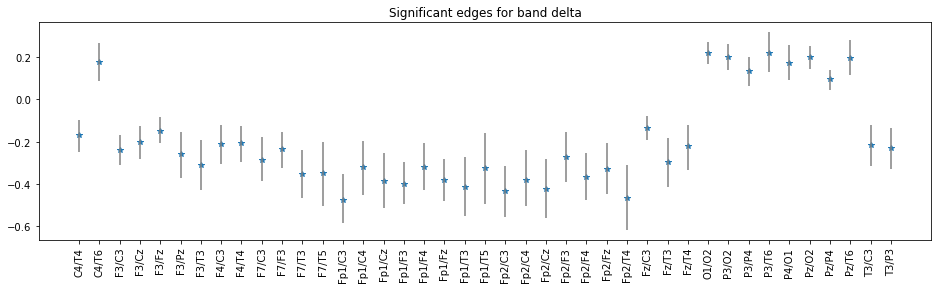

In [13]:
#выберем подгруппу размером size
analyzer.get_subgroup(size=170)
sign_channels = analyzer.bootstrap_significant_channels(band=1,
                                       plot=True, num_btsp=1000, conf_levels=[5, 95])

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 589.36it/s]


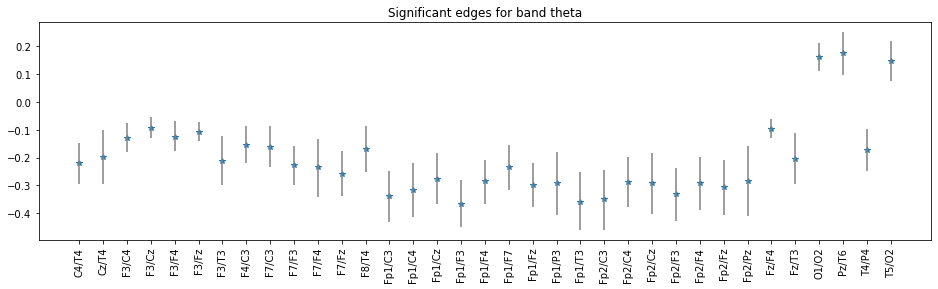

In [31]:
sign_channels = analyzer.bootstrap_significant_channels(band=2,
                                       plot=True, num_btsp=1000, conf_levels=[5, 95])

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 562.25it/s]


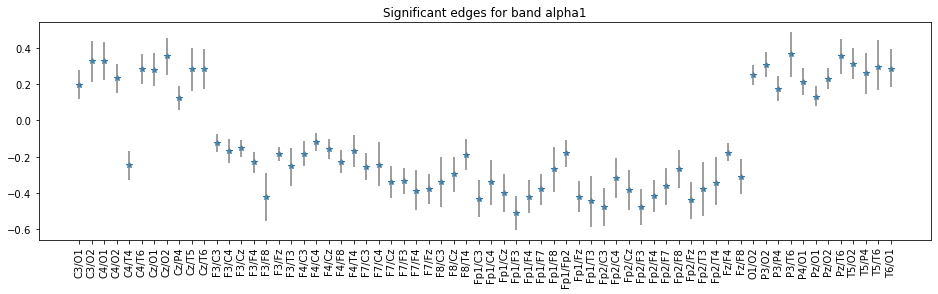

In [32]:
sign_channels = analyzer.bootstrap_significant_channels(band=3,
                                       plot=True, num_btsp=1000, conf_levels=[5, 95])

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 593.15it/s]


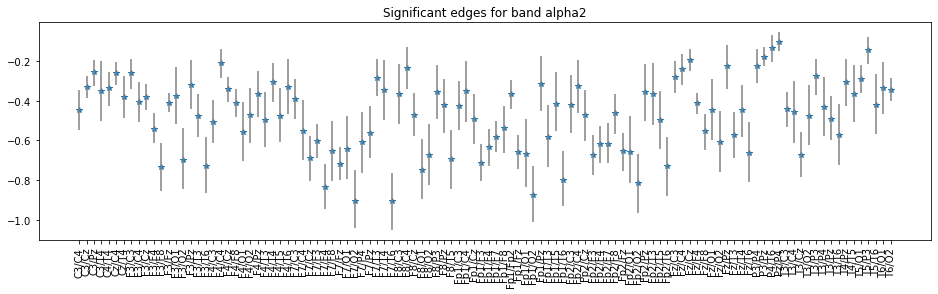

In [33]:
sign_channels = analyzer.bootstrap_significant_channels(band=4,
                                       plot=True, num_btsp=1000, conf_levels=[5, 95])

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 518.59it/s]


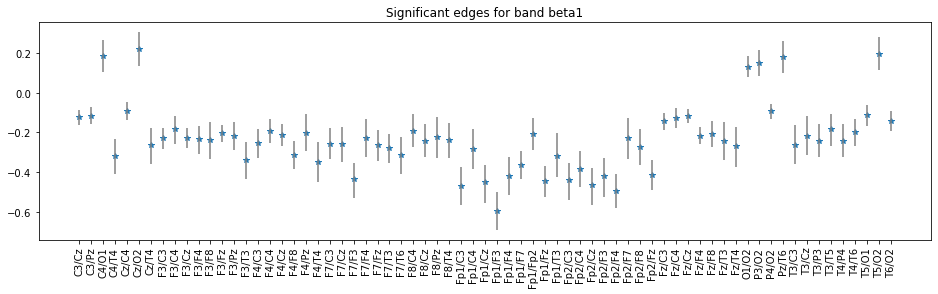

In [34]:
sign_channels = analyzer.bootstrap_significant_channels(band=5,
                                       plot=True, num_btsp=1000, conf_levels=[5, 95])

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 583.78it/s]


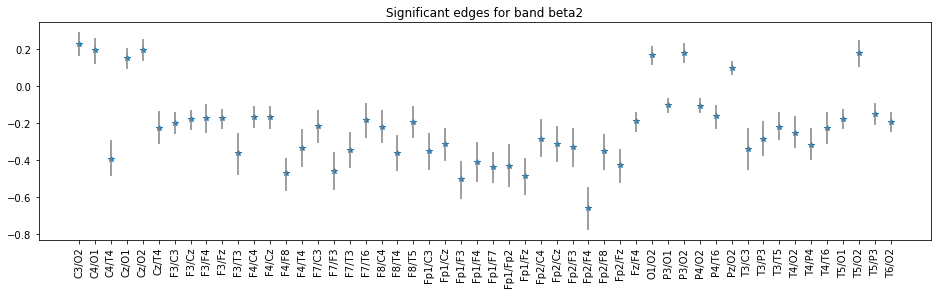

In [35]:
sign_channels = analyzer.bootstrap_significant_channels(band=6,
                                       plot=True, num_btsp=1000, conf_levels=[5, 95])

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 570.21it/s]


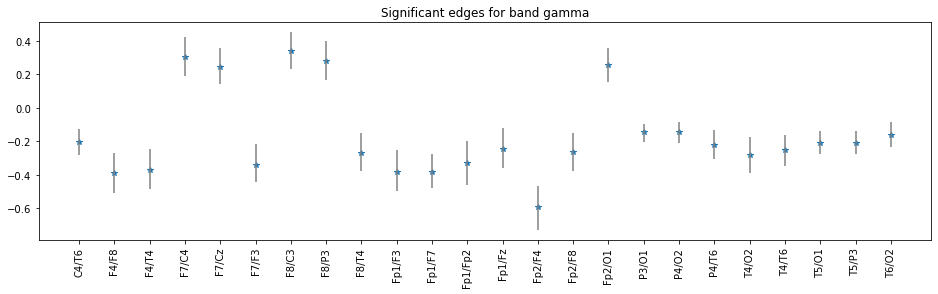

In [36]:
sign_channels = analyzer.bootstrap_significant_channels(band=7,
                                       plot=True, num_btsp=1000, conf_levels=[5, 95])

## Выявление значимых каналов для конкретного эксперимента
Получение с помощью теста на перемешивания значимых пар каналов для конкретного эксперимента, задаем число симуляций и уровень значимости (с поправкой на множественность сравнений)
Посмотрим как будет результат меняться для разного размера выборок, возьмем очень маленький p-value, с самой строгой поправкой на множественные сравнения 0.05/171

При этом при каждом новом запуске результаты будут отличаться!

In [5]:
vmin_=-1.5
vmax_=1.5
cmap = cm.seismic

In [50]:
6*29

174

## !Сделать

проверить связь - воспроизводимость паттерна и уровень значимости на разных (непересекающихся) подгруппах

Отранжировать по убыванию значимости и посмотреть воспроизводятся ли более значимые разницы лучше чем менее и получить какие-то статистики для этого

Взять 6 непересекающихся групп по 29 человек и посмотреть пропутешествует ли эффект по группам

Для группы 177 человек сделать бутстрап с повторением и посмотреть что гарантировано остается

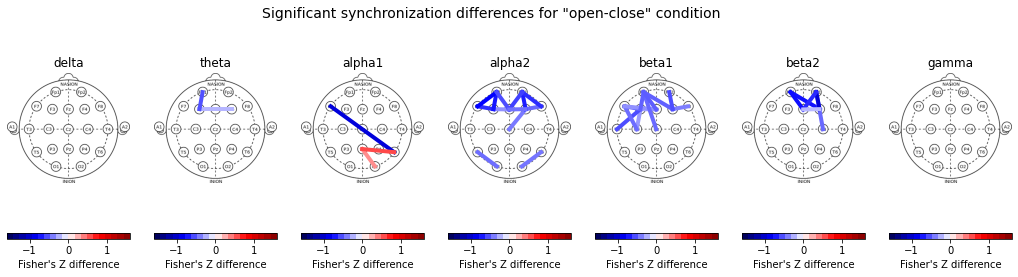

In [28]:
group_size = 30
obj = plot_compute_sign_differences(size=group_size, band=[1,2,3,4,5,6,7], num_perms=10000, thres=0.0003,
                                            title=None, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

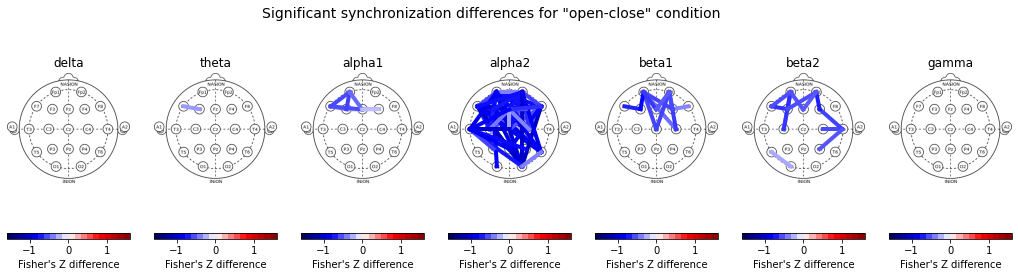

In [43]:
group_size = 40
obj = plot_compute_sign_differences(size=group_size, band=[1,2,3,4,5,6,7], num_perms=10000, thres=0.0003,
                                            title=None, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

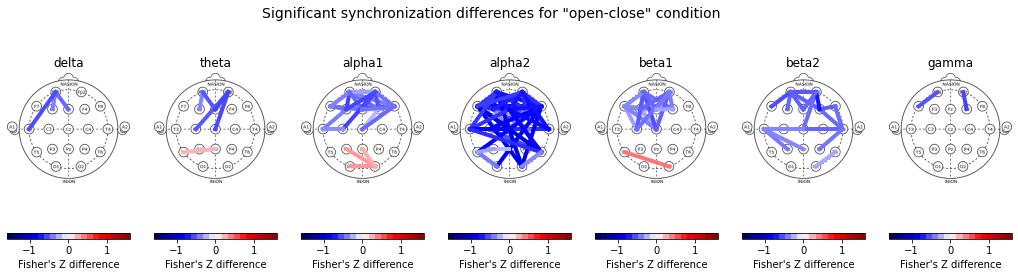

In [22]:
group_size = 50
obj = plot_compute_sign_differences(size=group_size, band=[1,2,3,4,5,6,7], num_perms=10000, thres=0.0003,
                                            title=None, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

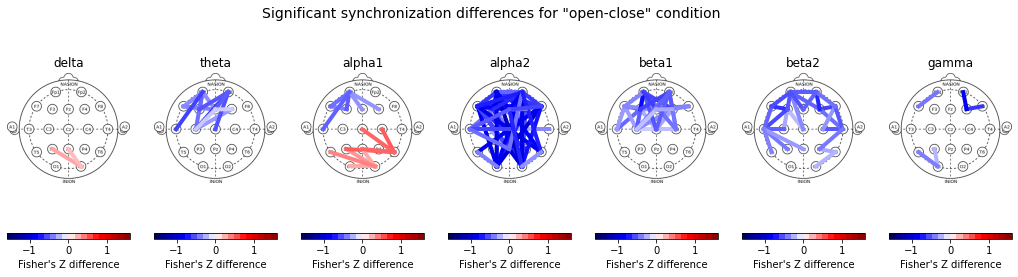

In [23]:
group_size = 60
obj = plot_compute_sign_differences(size=group_size, band=[1,2,3,4,5,6,7], num_perms=10000, thres=0.0003,
                                            title=None, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

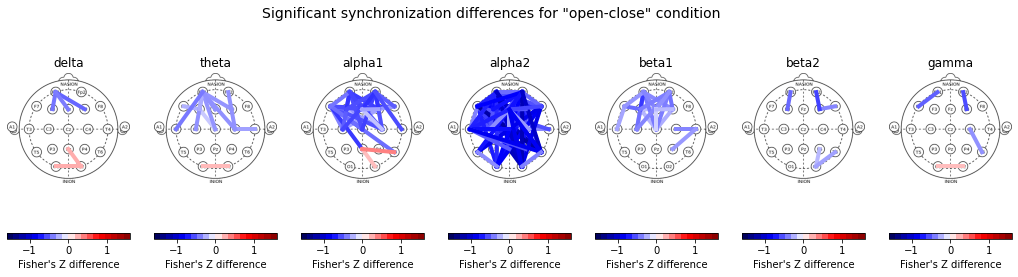

In [24]:
group_size = 70
obj = plot_compute_sign_differences(size=group_size, band=[1,2,3,4,5,6,7], num_perms=10000, thres=0.0003,
                                            title=None, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

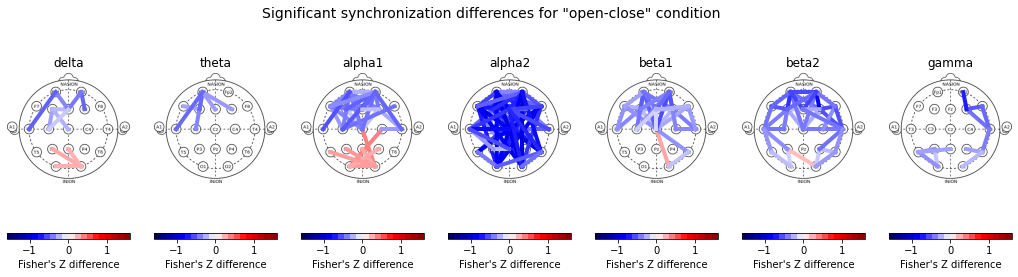

In [26]:
group_size = 80
obj = plot_compute_sign_differences(size=group_size, band=[1,2,3,4,5,6,7], num_perms=10000, thres=0.0003,
                                            title=None, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

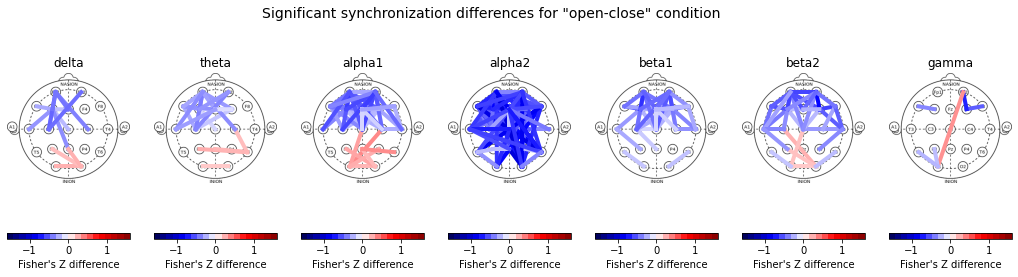

In [25]:
group_size = 100
obj = plot_compute_sign_differences(size=group_size, band=[1,2,3,4,5,6,7], num_perms=10000, thres=0.0003,
                                            title=None, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

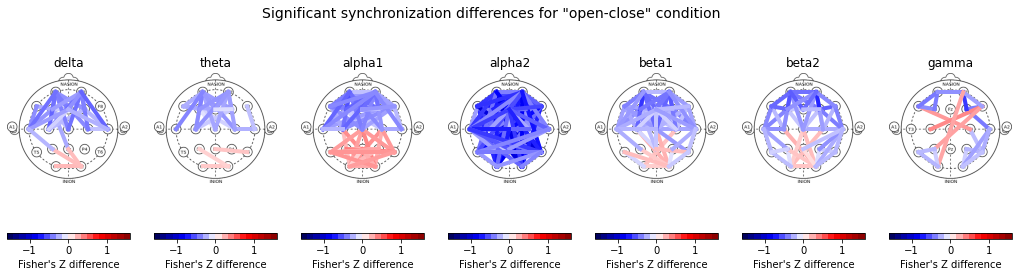

In [27]:
group_size = 177
obj = plot_compute_sign_differences(size=group_size, band=[1,2,3,4,5,6,7], num_perms=10000, thres=0.0003,
                                            title=None, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

## Воспроизводимость паттерна в группе одного и того же размера

Сейчас посчитаем те же самые значимые разности, но добавим условие воспроизводимости. То есть в добавок к тому что для каждой подвыборки должна быть значимой, она должна появляться не менее чем в какой в скольки то процентах случаях. Эта переменная задаются с помощью доли: factor. При этом порог для уровня значимости предлагается снизить, так как в данном случае мы накладываем дополнительные ограничения и можно ослабить условие на множественные сравнения.


Оказалось, что с ростом числа испытуемых число воспроизводимых паттернов с заданным порогом существенно растет



100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.19it/s]


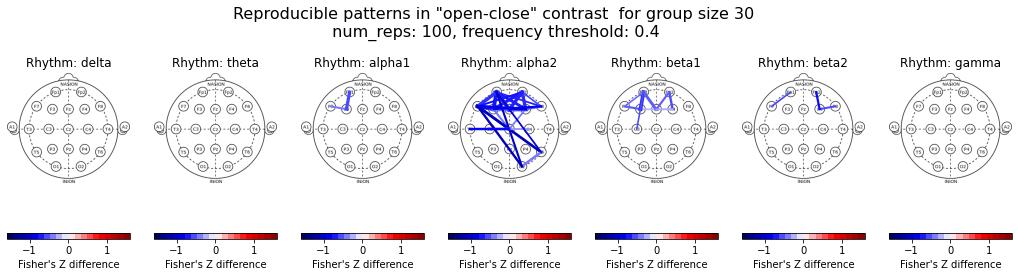

CPU times: user 35.4 s, sys: 900 ms, total: 36.3 s
Wall time: 35.8 s


In [31]:
%%time
group_size = 30
obj, pattern = plot_reproducibility_pattern(size=group_size, band=[1,2,3,4,5,6,7], num_perms=1000, num_reps=100, factor=0.4,
                                           thres=0.001, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.47it/s]


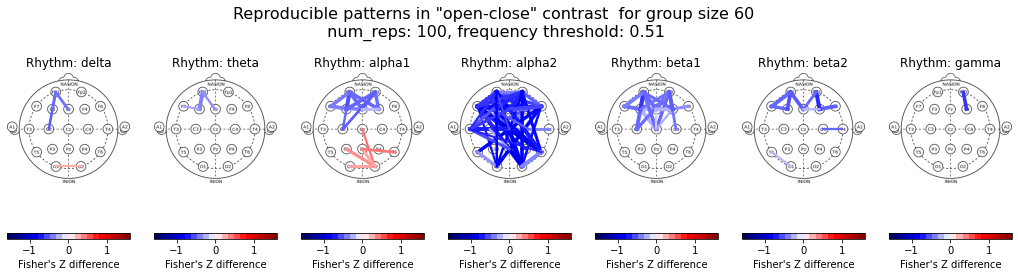

CPU times: user 41.4 s, sys: 1.02 s, total: 42.4 s
Wall time: 42 s


In [33]:
%%time
group_size = 60
obj, pattern = plot_reproducibility_pattern(size=group_size, band=[1,2,3,4,5,6,7], num_perms=1000, num_reps=100, factor=0.51,
                                           thres=0.001, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

In [35]:
#можно сохранить таблички с частотами 
for idx in range(7):
    print(f"Reproducible patterns for {obj.bands[idx]} rhythm")
    display(pd.DataFrame(pattern[idx]).sort_values('frequency', ascending=False))

Reproducible patterns for delta rhythm


,channels,frequency,mean_diff
1,Fp1/F3,0.96,-0.415680
2,Fp1/Fz,0.93,-0.396087
0,Fp1/C3,0.84,-0.470059
5,O1/O2,0.84,0.225538
7,Pz/O2,0.83,0.206518
8,F3/C3,0.73,-0.257262
6,P3/O2,0.65,0.223006
3,Fp2/C3,0.63,-0.459021
4,Fp2/F4,0.60,-0.409230
9,Fp1/T3,0.54,-0.485412


Reproducible patterns for theta rhythm


,channels,frequency,mean_diff
4,Fp1/F3,1.00,-0.362327
6,Fp1/Fz,0.83,-0.313484
1,F7/F3,0.80,-0.240606
5,Fp1/F4,0.77,-0.315776
3,Fp1/C3,0.75,-0.344048
7,O1/O2,0.63,0.184705
11,Fp2/F4,0.61,-0.331830
12,Fp2/Fz,0.61,-0.344048
10,Fp2/F3,0.58,-0.357895
0,C4/T4,0.55,-0.247376


Reproducible patterns for alpha1 rhythm


,channels,frequency,mean_diff
20,Fp2/F4,1.00,-0.417959
14,Fp1/F3,1.00,-0.511365
9,F7/F3,0.99,-0.340517
15,Fp1/F4,0.99,-0.430627
19,Fp2/F3,0.98,-0.461173
17,Fp1/Fz,0.98,-0.428042
24,P3/O2,0.97,0.311944
16,Fp1/F7,0.96,-0.396482
11,F7/Fz,0.96,-0.381394
25,Pz/O2,0.96,0.233627


Reproducible patterns for alpha2 rhythm


,channels,frequency,mean_diff
0,C3/Cz,1.00,-0.323694
38,Fp2/F3,1.00,-0.650735
26,F7/T6,1.00,-0.898495
28,F8/T5,1.00,-0.730507
29,Fp1/F3,1.00,-0.704157
...,...,...,...
76,Fz/C3,0.62,-0.298416
72,Fp1/C3,0.60,-0.469354
64,F4/C4,0.54,-0.253282
69,F7/T3,0.54,-0.328799


Reproducible patterns for beta1 rhythm


,channels,frequency,mean_diff
18,Fp1/F3,1.00,-0.588590
9,F4/F8,1.00,-0.334184
21,Fp1/Fz,1.00,-0.448898
20,Fp1/F7,1.00,-0.368360
28,Fp2/Fz,1.00,-0.420731
12,F7/F3,1.00,-0.432041
26,Fp2/F4,1.00,-0.498765
17,Fp1/Cz,0.99,-0.444296
5,F3/Fz,0.99,-0.207795
2,F3/C3,0.99,-0.230874


Reproducible patterns for beta2 rhythm


,channels,frequency,mean_diff
12,Fp2/F4,1.00,-0.650492
3,F4/F8,1.00,-0.461020
11,Fp1/Fz,1.00,-0.470290
9,Fp1/F3,0.99,-0.503709
10,Fp1/F7,0.99,-0.439719
5,F7/F3,0.97,-0.444008
14,Fp2/Fz,0.95,-0.427636
0,C4/T4,0.88,-0.423303
25,Fz/F4,0.85,-0.205680
24,Fp1/Fp2,0.81,-0.440058


Reproducible patterns for gamma rhythm


,channels,frequency,mean_diff
1,Fp2/F4,0.99,-0.589186
4,Fp1/F7,0.91,-0.405704
2,F4/F8,0.67,-0.430733
0,Fp1/F3,0.65,-0.427880
3,F4/T4,0.61,-0.434897


100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.90it/s]


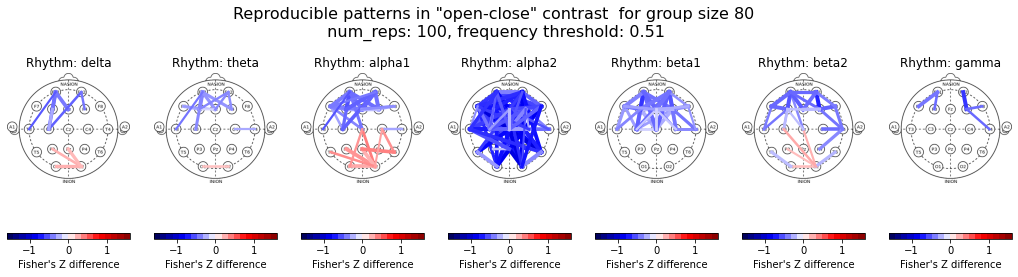

CPU times: user 44.1 s, sys: 1.05 s, total: 45.1 s
Wall time: 44.7 s


In [34]:
%%time
group_size = 80
obj, pattern = plot_reproducibility_pattern(size=group_size, band=[1,2,3,4,5,6,7], num_perms=1000, num_reps=100, factor=0.51,
                                           thres=0.001, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

In [74]:
for idx in range(7):
    print(f"Reproducible patterns for {obj.bands[idx]} rhythm")
    display(pd.DataFrame(pattern[idx]).sort_values('frequency', ascending=False))

Reproducible patterns for delta rhythm


,channels,frequency,mean_diff
3,Fp1/Fz,0.98,-0.381327
2,Fp1/F3,0.93,-0.414316
1,Fp1/C3,0.87,-0.468264
7,O1/O2,0.83,0.215463
0,F3/C3,0.77,-0.246212
8,Pz/O2,0.77,0.207647
5,Fp2/C3,0.63,-0.457870
6,Fp2/F4,0.59,-0.394441
9,P3/O2,0.55,0.218649
4,Fp1/T3,0.51,-0.473306


Reproducible patterns for theta rhythm


,channels,frequency,mean_diff
3,Fp1/F3,0.99,-0.371830
7,F7/F3,0.90,-0.240489
5,Fp1/Fz,0.85,-0.319472
2,Fp1/C3,0.76,-0.357429
4,Fp1/F4,0.71,-0.320001
0,C4/T4,0.63,-0.246608
8,Fp2/F3,0.59,-0.352324
6,O1/O2,0.54,0.183015
9,Fp2/F4,0.54,-0.326292
1,F3/Fz,0.51,-0.127193


Reproducible patterns for alpha1 rhythm


,channels,frequency,mean_diff
12,Fp1/Fz,1.00,-0.427005
9,Fp1/F3,1.00,-0.515261
5,F7/F3,0.99,-0.347376
15,Fp2/F4,0.99,-0.413386
10,Fp1/F4,0.99,-0.427593
14,Fp2/F3,0.99,-0.458624
4,F3/Fz,0.97,-0.186953
11,Fp1/F7,0.96,-0.395030
6,F7/Fz,0.96,-0.383581
19,P3/O2,0.95,0.311950


Reproducible patterns for alpha2 rhythm


,channels,frequency,mean_diff
38,Fp1/F4,1.00,-0.625933
49,Fp2/F7,1.00,-0.608896
37,Fp1/F3,1.00,-0.705328
1,C3/Cz,1.00,-0.323702
39,Fp1/F7,1.00,-0.590132
...,...,...,...
68,Fp1/C3,0.60,-0.462778
18,F4/T3,0.60,-0.526217
32,F7/T3,0.60,-0.307073
56,Fz/C3,0.59,-0.301599


Reproducible patterns for beta1 rhythm


,channels,frequency,mean_diff
11,F7/F3,1.00,-0.420950
20,Fp2/C3,1.00,-0.430395
25,Fp2/Fz,1.00,-0.409596
19,Fp1/Fz,1.00,-0.441764
18,Fp1/F7,1.00,-0.365039
24,Fp2/F4,1.00,-0.482650
22,Fp2/Cz,1.00,-0.458210
13,Fp1/C3,1.00,-0.459816
16,Fp1/F3,1.00,-0.584304
15,Fp1/Cz,0.99,-0.446611


Reproducible patterns for beta2 rhythm


,channels,frequency,mean_diff
16,Fp2/F4,1.00,-0.637284
6,F4/F8,1.00,-0.462105
11,Fp1/F3,0.99,-0.488421
7,F7/F3,0.99,-0.440885
15,Fp1/Fz,0.99,-0.469476
13,Fp1/F7,0.99,-0.431381
18,Fp2/Fz,0.96,-0.417653
21,T5/O1,0.86,-0.198151
19,Fz/F4,0.84,-0.208232
1,C4/T4,0.83,-0.410363


Reproducible patterns for gamma rhythm


,channels,frequency,mean_diff
3,Fp2/F4,0.97,-0.587558
2,Fp1/F7,0.78,-0.403623
0,F4/F8,0.60,-0.422111
1,Fp1/F3,0.55,-0.429545
4,F4/T4,0.54,-0.423121
5,T5/O1,0.51,-0.251024


100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.97it/s]


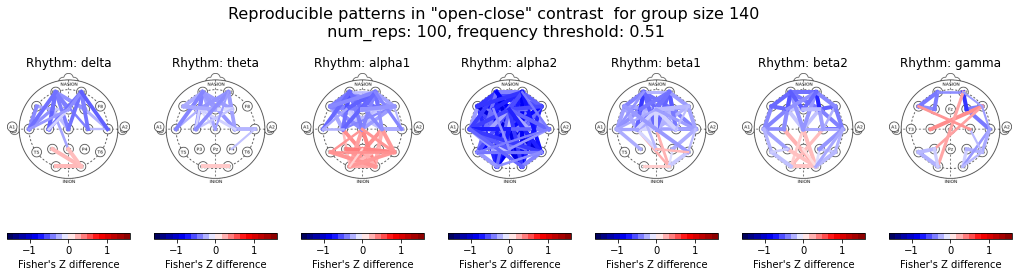

CPU times: user 51.1 s, sys: 1.06 s, total: 52.2 s
Wall time: 51.8 s


In [36]:
%%time
group_size = 140
obj, pattern = plot_reproducibility_pattern(size=group_size, band=[1,2,3,4,5,6,7], num_perms=1000, num_reps=100, factor=0.51,
                                           thres=0.001, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

In [37]:
for idx in range(7):
    print(f"Reproducible patterns for {obj.bands[idx]} rhythm")
    display(pd.DataFrame(pattern[idx]).sort_values('frequency', ascending=False)[:5])

Reproducible patterns for delta rhythm


,channels,frequency,mean_diff
26,Pz/O2,1.0,0.196384
12,Fp1/F3,1.0,-0.412073
24,O1/O2,1.0,0.210125
14,Fp1/Fz,1.0,-0.381710
1,F3/C3,1.0,-0.232865


Reproducible patterns for theta rhythm


,channels,frequency,mean_diff
12,Fp1/Fz,1.0,-0.304264
19,O1/O2,1.0,0.161426
5,F7/F3,1.0,-0.231301
15,Fp2/F3,1.0,-0.315324
9,Fp1/F3,1.0,-0.366505


Reproducible patterns for alpha1 rhythm


,channels,frequency,mean_diff
31,Fp1/F4,1.0,-0.424004
29,Fp1/Cz,1.0,-0.378639
53,Pz/O2,1.0,0.232987
30,Fp1/F3,1.0,-0.510586
32,Fp1/F7,1.0,-0.383065


Reproducible patterns for alpha2 rhythm


,channels,frequency,mean_diff
0,C3/C4,1.0,-0.442610
40,F7/T6,1.0,-0.895882
63,Fp2/F4,1.0,-0.604958
62,Fp2/F3,1.0,-0.639093
61,Fp2/Cz,1.0,-0.444976


Reproducible patterns for beta1 rhythm


,channels,frequency,mean_diff
29,Fp1/F3,1.0,-0.582677
16,F4/Cz,1.0,-0.220060
33,Fp1/Fz,1.0,-0.441464
28,Fp1/Cz,1.0,-0.440630
35,Fp2/C3,1.0,-0.422536


Reproducible patterns for beta2 rhythm


,channels,frequency,mean_diff
0,C3/O2,1.0,0.228021
14,F7/F3,1.0,-0.439331
42,T6/O2,1.0,-0.209601
41,T5/O1,1.0,-0.186590
31,Fz/F4,1.0,-0.200689


Reproducible patterns for gamma rhythm


,channels,frequency,mean_diff
0,F4/F8,1.0,-0.384712
1,F4/T4,1.0,-0.393148
6,Fp1/F7,1.0,-0.389510
14,T5/O1,1.0,-0.223164
8,Fp2/F4,1.0,-0.588448


100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.19it/s]


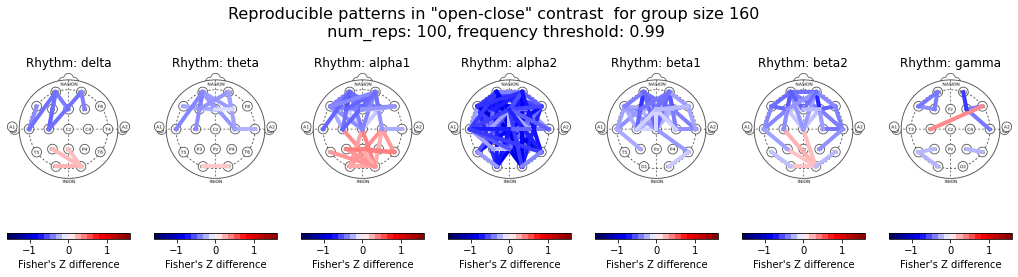

CPU times: user 52.8 s, sys: 1.04 s, total: 53.9 s
Wall time: 53.4 s


In [38]:
%%time
group_size = 160
obj, pattern = plot_reproducibility_pattern(size=group_size, band=[1,2,3,4,5,6,7], num_perms=1000, num_reps=100, factor=0.99,
                                           thres=0.001, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))

In [39]:
for idx in range(7):
    print(f"Reproducible patterns for {obj.bands[idx]} rhythm")
    display(pd.DataFrame(pattern[idx]).sort_values('frequency', ascending=False)[:5])

Reproducible patterns for delta rhythm


,channels,frequency,mean_diff
0,F3/C3,1.0,-0.233399
1,F7/T3,1.0,-0.337197
2,Fp1/C3,1.0,-0.447681
3,Fp1/F3,1.0,-0.412545
4,Fp1/Fz,1.0,-0.379123


Reproducible patterns for theta rhythm


,channels,frequency,mean_diff
0,C4/T4,1.0,-0.225485
1,F3/Fz,1.0,-0.113117
2,F7/F3,1.0,-0.231521
4,Fp1/C3,1.0,-0.331547
6,Fp1/F3,1.0,-0.364048


Reproducible patterns for alpha1 rhythm


,channels,frequency,mean_diff
0,C3/O2,1.0,0.337017
29,Fp2/F4,1.0,-0.411818
22,Fp1/F7,1.0,-0.380933
23,Fp1/Fz,1.0,-0.423122
24,Fp1/T3,1.0,-0.448920


Reproducible patterns for alpha2 rhythm


,channels,frequency,mean_diff
0,C3/C4,1.0,-0.442876
1,C3/Cz,1.0,-0.322627
59,Fp2/F8,1.0,-0.457184
58,Fp2/F7,1.0,-0.602671
57,Fp2/F4,1.0,-0.608297


Reproducible patterns for beta1 rhythm


,channels,frequency,mean_diff
0,C3/Cz,1.0,-0.123048
19,Fp1/C3,1.0,-0.451949
21,Fp1/Cz,1.0,-0.438015
22,Fp1/F3,1.0,-0.588574
23,Fp1/F4,1.0,-0.408655


Reproducible patterns for beta2 rhythm


,channels,frequency,mean_diff
0,C3/O2,1.0,0.225552
16,Fp1/F3,1.0,-0.490174
32,T5/O1,1.0,-0.187310
31,T4/P4,1.0,-0.318953
30,T3/P3,1.0,-0.278548


Reproducible patterns for gamma rhythm


,channels,frequency,mean_diff
0,F4/F8,1.0,-0.386021
1,F4/T4,1.0,-0.390838
3,F8/C3,1.0,0.345949
4,Fp1/F3,1.0,-0.380461
5,Fp1/F7,1.0,-0.389211


100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:34<00:00,  1.30it/s]


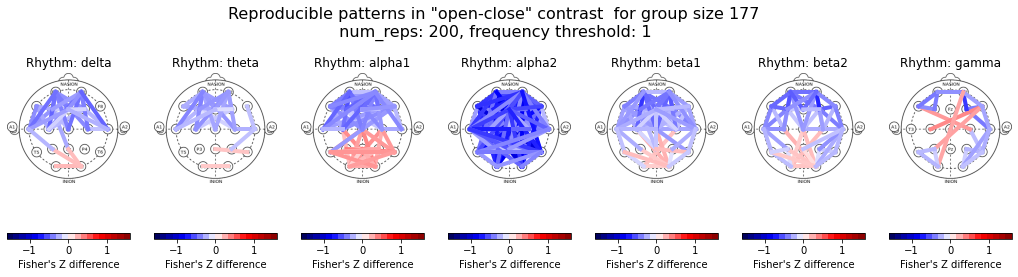

CPU times: user 17min 29s, sys: 18.2 s, total: 17min 48s
Wall time: 17min 48s


In [9]:
%%time
group_size = 177
obj, pattern = plot_reproducibility_pattern(size=group_size, band=[1,2,3,4,5,6,7], num_perms=10000, num_reps=200, factor=1,
                                           thres=0.001, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4), replace=True)

In [48]:
for idx in range(7):
    print(f"Reproducible patterns for {obj.bands[idx]} rhythm")
    display(pd.DataFrame(pattern[idx]).sort_values('frequency', ascending=False)[:5])

Reproducible patterns for delta rhythm


,channels,frequency,mean_diff
0,F3/C3,1.0,-0.233319
9,Fp2/C3,1.0,-0.412888
14,O1/O2,1.0,0.210575
13,Fp2/T4,1.0,-0.454961
12,Fp2/F4,1.0,-0.367030


Reproducible patterns for theta rhythm


,channels,frequency,mean_diff
0,C4/T4,1.0,-0.222060
1,F3/Fz,1.0,-0.113676
2,F7/F3,1.0,-0.232593
3,F7/Fz,1.0,-0.256339
4,Fp1/C3,1.0,-0.332859


Reproducible patterns for alpha1 rhythm


,channels,frequency,mean_diff
0,C3/O2,1.0,0.339542
35,Fp2/F7,1.0,-0.345198
26,Fp1/F3,1.0,-0.510585
27,Fp1/F4,1.0,-0.424716
28,Fp1/F7,1.0,-0.383357


Reproducible patterns for alpha2 rhythm


,channels,frequency,mean_diff
0,C3/C4,1.0,-0.443357
53,Fp1/T3,1.0,-0.579009
62,Fp2/O1,1.0,-0.677691
61,Fp2/Fz,1.0,-0.646835
60,Fp2/F8,1.0,-0.458637


Reproducible patterns for beta1 rhythm


,channels,frequency,mean_diff
0,C3/Cz,1.0,-0.122817
34,Fp2/F4,1.0,-0.486221
25,Fp1/F3,1.0,-0.586570
26,Fp1/F4,1.0,-0.411564
27,Fp1/F7,1.0,-0.364046


Reproducible patterns for beta2 rhythm


,channels,frequency,mean_diff
0,C3/O2,1.0,0.224254
1,C4/T4,1.0,-0.403863
33,T5/O1,1.0,-0.186943
32,T4/P4,1.0,-0.318931
29,P3/O2,1.0,0.175624


Reproducible patterns for gamma rhythm


,channels,frequency,mean_diff
0,F4/F8,1.0,-0.384950
1,F4/T4,1.0,-0.390372
2,F7/F3,1.0,-0.337052
3,F8/C3,1.0,0.342835
4,Fp1/F3,1.0,-0.381529
